# Legolas Outline

Use this code to answer the challenges.

In [2]:
import utils
from core import *

In [ ]:
# this is how you reset the rpyc server when facing the port already in use
# need to change to actual host name
host_1 = "192.168.0.4"
host_2 = "192.168.0.5"

utils.restart_server(host=host_1)
utils.restart_server(host=host_2)

kill server at PID:2664
restarting the rpyc server at host: 192.168.0.4
rpyc server start successfully
kill server at PID:15306
restarting the rpyc server at host: 192.168.0.5
rpyc server start successfully


Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)


In [15]:
stage, depo_device, pH_device, conn1, conn2, config = load_from_config(r"C:\Users\drago\Documents\GitHub\LEGOLAS-Files\config_11_27_23.yaml")

In [8]:
# it is ok if this fails, just move on to the next code block
sanity_check(stage=stage, pH_device=pH_device, depo_device=depo_device)

AssertionError: 

In [9]:
# find the usb port if problem occur
list_ports = conn1.modules['serial.tools.list_ports']

ports=list_ports.comports()
for port, desc, hwid in sorted(ports):
    print(port, desc, hwid)

/dev/ttyACM0 ttyACM0 USB VID:PID=2341:0043 SER=9553034393435130E032 LOCATION=1-1.1:1.0
/dev/ttyAMA0 ttyAMA0 fe201000.serial


In [16]:
# Go to Home Position
reset(stage=stage, pH_device=pH_device, depo_device=depo_device)
# stage.home()

In [17]:
def depo(acid:bool,volume:float,row:int,col:int):
    if acid:
        loc="acid"
    else:
        loc="base"
    while volume>0.6:
        depo_device.acquire(0.6, location=loc)
        print(f"Acquired 0.6ml of {loc}")
        depo_device.deposition(0.6, row=row, col=col)
        volume-=0.6
        print(f"Deposited 0.6ml of {loc} in ({row},{col})")
    if volume >= 0.04:
        depo_device.acquire(volume, location=loc)
        print(f"Acquired {volume}ml of {loc}")
        depo_device.deposition(volume, row=row, col=col)
        print(f"Deposited {volume}ml of {loc} in ({row},{col})")
    return None

def mix_ab(a:float,b:float,row:int,col:int):
    """
    a+b will be normalized to a volume of 2ml
    """
    acid=2*a/(a+b)
    base=2*b/(a+b)
    print(f"Mixing {acid}ml of acid and {base}ml of base in ({row},{col})")
    depo(acid=True,volume=acid,row=row,col=col)
    depo(acid=False,volume=base,row=row,col=col)

def clean_ph():
    pH_device.move_to_loc("clean")
    pH_device.to_zpos("full_down")
    pH_device.to_zpos("full_up")
    print("Cleaned pH Probe")

def measured_ph(row,col):
    pH_device.move_to_cell(row=row, col=col)
    pH = pH_device.pH_measure(stable_time=20) ###should be 20 for actual run
    print(f"row {row} col {col} pH {pH}")
    return pH

class cell_grid():
    def __init__(self,rows,cols,start=0,**filled):
        self.rows=rows
        self.cols=cols
        self.start=start
        np.fromfunction(lambda r,c:(r,c),(rows,cols))

## (1) Measurement Uncertainty

**(a)** Write a script to create a sample with an equal amount of acid and base (Total volume should be 2 ml and each deposition sequence should not exceed 0.6 mL for LEGOLAS to function properly)

**(b)** Write a script to follow these operations in a loop with 10 measurements:
-  Dip the pH sensor in the DI water well
-  Dip the pH sensor into the sample from (a), measure pH and record.

**(c)** Plot the results from (b). 

What is the mean and variance of these measurements? Please include this information as markdown text in the Jupyter notebook.


### (a)
Write a script to create a sample with an equal amount of acid and base (Total volume should be 2 ml and each deposition sequence should not exceed 0.6 mL for LEGOLAS to function properly)

In [28]:
mix_ab(0.5,0.5,2,2)

Mixing 1.0ml of acid and 1.0ml of base in (2,2)
Acquired 0.6ml of acid
Deposited 0.6ml of acid in (2,2)
Acquired 0.4ml of acid
Deposited 0.4ml of acid in (2,2)
Acquired 0.6ml of base
Deposited 0.6ml of base in (2,2)
Acquired 0.4ml of base
Deposited 0.4ml of base in (2,2)


### (b)
Write a script to follow these operations in a loop with 10 measurements:
-  Dip the pH sensor in the DI water well
-  Dip the pH sensor into the sample from (a), measure pH and record.

In [29]:
def ph_cycle(iterations,row,col):
    measurement_cycles=list(range(iterations))
    phs=[]
    for i in measurement_cycles:
        print(f"Starting iteration {i}:")
        clean_ph()
        phs.append(measured_ph(row,col))
    return phs,measurement_cycles
phs,cycles=ph_cycle(10,2,2)

Starting iteration 0:
Cleaned pH Probe
pH is Measured as: 4.35
row 2 col 2 pH 4.35
Starting iteration 1:
Cleaned pH Probe
pH is Measured as: 4.35
row 2 col 2 pH 4.35
Starting iteration 2:
Cleaned pH Probe
pH is Measured as: 4.35
row 2 col 2 pH 4.35
Starting iteration 3:
Cleaned pH Probe
pH is Measured as: 4.36
row 2 col 2 pH 4.36
Starting iteration 4:
Cleaned pH Probe
pH is Measured as: 4.35
row 2 col 2 pH 4.35
Starting iteration 5:
Cleaned pH Probe
pH is Measured as: 4.36
row 2 col 2 pH 4.36
Starting iteration 6:
Cleaned pH Probe
pH is Measured as: 4.36
row 2 col 2 pH 4.36
Starting iteration 7:
Cleaned pH Probe
pH is Measured as: 4.36
row 2 col 2 pH 4.36
Starting iteration 8:
Cleaned pH Probe
pH is Measured as: 4.35
row 2 col 2 pH 4.35
Starting iteration 9:
Cleaned pH Probe
pH is Measured as: 4.36
row 2 col 2 pH 4.36


### (c)
Plot the results from (b). 

What is the mean and variance of these measurements? Please include this information as markdown text in the Jupyter notebook.

Mean: 4.355
Variance: 2.500000000000338e-05


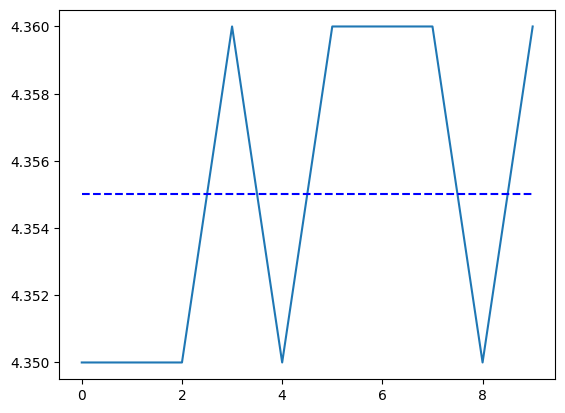

In [30]:
from matplotlib import pyplot as plt
plt.plot(cycles,phs)
print("Mean:",np.mean(phs))
print("Variance:",np.var(phs))
plt.plot([cycles[0],cycles[-1]],[np.mean(phs),np.mean(phs)],linestyle="--",c="b")
# plt.ylim(3,11)
plt.show()

Mean: 4.355

Variance: $2.5*10^{-5}$

We suspect this value is slightly off due to calibration but it demonstrates that we are able to carry out this process.

## (2) The Henderson Hasselbach Equation

The HH equation is given as:
$pH = pK - log(\frac{[Acid]}{[Base]})$

The output gives the pH of the sample, pK is a constant, and [Acid] and [Base] are the **concentrations** of acid and base.  For these experiments we will work with the percentage of acid in the sample to create samples varying in composition from a percentage of acid of 10% through 80%.  

**(a)** Write code that will create 8 samples of mixture amounts: acid [10%, 20%, ... 80%]

**(b)** After each sample is made, have the system dip the pH sensor in the DI water well, and then measure the pH of the sample.  Plot the measured pH as a function of the [acid]/[base] **ratio**.  

**(c)** Run the code created during steps (a) and (b) (this should be one for loop accomplishing both tasks together).  Then plot the results.  

**(d)** We will now fit the HH equation to the data.  Write a function that takes in the [acid]/[base] ratio **x** and returns the **pH**, following this equation:
-  Func(x, pK) = pK - log(x), where x = [acid]/[base]

**(e)** Follow the example for the scipy function "curve_fit" to fit this function to the data you have measured: 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

(use default method and no optional parameters)

**(f)** What is the pK value discovered?


### (a)
Write code that will create 8 samples of mixture amounts: acid [10%, 20%, ... 80%]

### (b)
After each sample is made, have the system dip the pH sensor in the DI water well, and then measure the pH of the sample.  Plot the measured pH as a function of the [acid]/[base] **ratio**.

### (c)
Run the code created during steps (a) and (b) (this should be one for loop accomplishing both tasks together).  Then plot the results.  

In [18]:
mixes=np.linspace(0.1,0.8,8)
cells=[(0,3),(0,4),(0,5),(1,0),(1,1),(1,2),(1,3),(1,4)]#row,col
ph_data=[]

for i,mix in enumerate(mixes):
    a=mix
    b=1-mix
    mix_ab(a,b,*cells[i])
    clean_ph()
    ph_data.append(measured_ph(*cells[i]))
plt.plot(mixes,ph_data)
plt.xlabel("Acid")
plt.ylabel("pH")
#during first run it crashed/TimeoutError after drawing up the first quantity of base and before raising the Z syringe.
    #made it through that spot the next time after full reseting.
    #timed out before drawing up the third 0.6ml of base.
    #liquid motor is locked. Nothing else is.
#stopped after drawing third -> was issue with the depo function with 0 volume. Changed limit to ignore less than 0.1 volume.
# New TypeError: fail to decode message from pH device. raw messsage: b'4\xfe4.14\r\n'.
    #Failed on 0.7
    #TA Recommendation: Use a bit longer stabalization time.
    #Error had not been seen before.

Mixing 0.2ml of acid and 1.8ml of base in (0,3)
Acquired 0.2ml of acid
Deposited 0.2ml of acid in (0,3)
Acquired 0.6ml of base
Deposited 0.6ml of base in (0,3)
Acquired 0.6ml of base
Deposited 0.6ml of base in (0,3)
Acquired 0.6ml of base
Deposited 0.6ml of base in (0,3)
Cleaned pH Probe
pH is Measured as: 3.64
row 0 col 3 pH 3.64
Mixing 0.4ml of acid and 1.6ml of base in (0,4)
Acquired 0.4ml of acid
Deposited 0.4ml of acid in (0,4)
Acquired 0.6ml of base
Deposited 0.6ml of base in (0,4)
Acquired 0.6ml of base
Deposited 0.6ml of base in (0,4)
Acquired 0.4ml of base
Deposited 0.4ml of base in (0,4)
Cleaned pH Probe
pH is Measured as: 5.12
row 0 col 4 pH 5.12
Mixing 0.6000000000000001ml of acid and 1.4ml of base in (0,5)
Acquired 0.6ml of acid
Deposited 0.6ml of acid in (0,5)
Acquired 0.6ml of base
Deposited 0.6ml of base in (0,5)
Acquired 0.6ml of base
Deposited 0.6ml of base in (0,5)
Acquired 0.19999999999999996ml of base
Deposited 0.19999999999999996ml of base in (0,5)
Cleaned pH Prob

TypeError: unsupported format string passed to bytes.__format__

[3.64, 5.12, 4.89, 4.67, 4.5, 4.32]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]


Text(0, 0.5, 'pH')

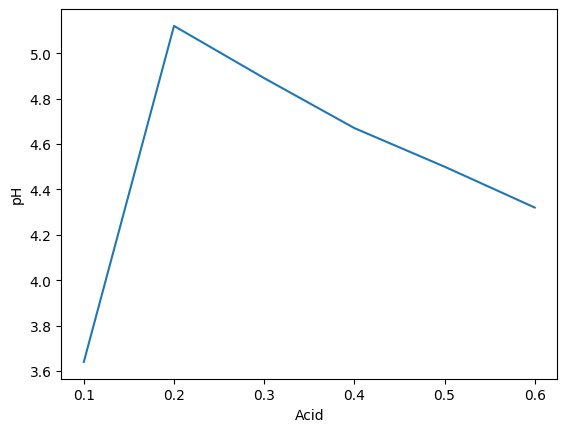

In [22]:
print(ph_data)
print(mixes)
plt.plot(mixes[:-2],ph_data)
plt.xlabel("Acid")
plt.ylabel("pH")

We definitely need to let our probe stabalize more. Increasing wait time from 1 to 20

### (d)
We will now fit the HH equation to the data.  Write a function that takes in the [acid]/[base] ratio **x** and returns the **pH**, following this equation:
-  Func(x, pK) = pK - log(x), where x = [acid]/[base]

### (e)
Follow the example for the scipy function "curve_fit" to fit this function to the data you have measured: 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

(use default method and no optional parameters)

pKa value from fitting: [4.74001012]


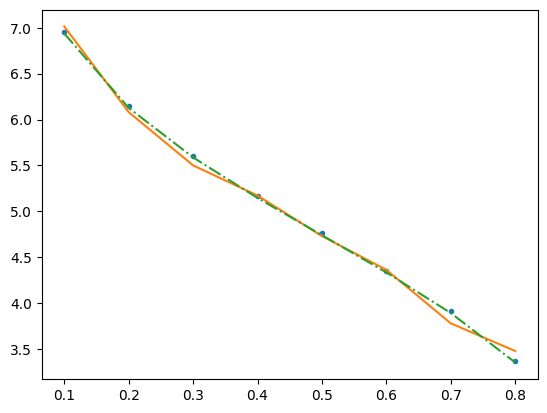

In [1]:
from scipy.optimize import curve_fit
def ph_hh(x,pk):
    """
    - x is [acid]/[base] ratio
    - pk is pKa of the weak acid
    - pH is returned
    """
    return pk-np.log(x)

# Generate demo data
import numpy as np
from matplotlib import pyplot as plt
mock_pk=4.76
mixes=np.linspace(0.1,0.8,8)
x_ratio=mixes/(1-mixes)
mock_ph=ph_hh(x_ratio,mock_pk)
gaussian_noise = np.random.normal(0, 0.1, mock_ph.shape)
mock_ph_data=mock_ph+gaussian_noise

#fit ph data
ph_data=mock_ph_data
x_ratio=mixes/(1-mixes)
fit_pk=curve_fit(ph_hh,x_ratio,ph_data)
print("pKa value from fitting:",fit_pk[0])
fit_ph=ph_hh(x_ratio,fit_pk[0])

plt.plot(mixes,mock_ph,".")
plt.plot(mixes,mock_ph_data)
plt.plot(mixes,fit_ph,"-.")

plt.show()

### (f) What is the pK value discovered?

4.727 from mock data

## (3) Gaussian Process 

**(a)** Fit the data with Gaussian process regression using an RBF kernel.  Optimize the hyperparameters and plot the results.  Output the GP hyperparameters: kernel length scale, kernel variance, noise variance.


In [2]:
# %pip install numpy==1.23
# %pip list
#error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
#https://visualstudio.microsoft.com/visual-cpp-build-tools/
# %pip install GPy
# %pip install GPyOpt
#https://github.com/SheffieldML/GPy
# %pip freeze -> requirements.txt

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import GPy
import GPyOpt

In [3]:

X=x_ratio.reshape(x_ratio.shape[0], 1)
Y=ph_data.reshape(x_ratio.shape[0], 1)
print(X.shape)
print(Y.shape)

(8, 1)
(8, 1)


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s01  007   1.266126e+01   6.063814e-01 
    00s01  010   1.163244e+01   5.281527e-02 

    00s03  017   1.122078e+01   2.869642e-03 
    00s03  023   1.121560e+01   2.105342e-11 
    00s05  024   1.121560e+01   2.105342e-11 
Runtime:     00s05
Optimization status: Converged



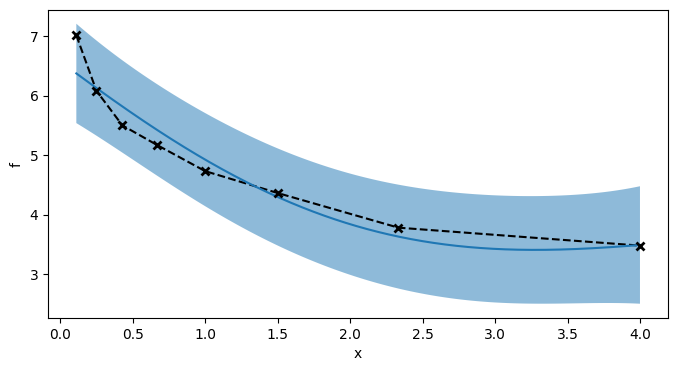


Name : GP regression
Objective : 11.215601893645001
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   45.592681211611804  |      +ve      |        
  rbf.lengthscale          |    3.751249245034946  |      +ve      |        
  Gaussian_noise.variance  |  0.13036149871621253  |      +ve      |        


In [22]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")

    plt.xlabel("x"), plt.ylabel("f")

    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)

ph_data=np.array(mock_ph_data)
x_ratio=np.array(mixes/(1-mixes))

X=x_ratio.reshape(x_ratio.shape[0], 1)
Y=ph_data.reshape(x_ratio.shape[0], 1)
# Set up the kernel and the GP model
k = GPy.kern.RBF(1)
m = GPy.models.GPRegression(
    X=X, 
    Y=Y,
    kernel=k)

# optimize hyperparameters
m.optimize(messages=True, max_iters=100)#

x_range=np.linspace(min(X),max(X),1000)

# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(x_range, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,4))
plt.plot(X, Y,'k--')
# plt.plot(x_range,mean)
plot_gp(x_range, mean, Cov, training_points=(X,Y))
plt.show()
print(m)


**(b)** Do the same, but this time with the data for x = [10%,...,60%]



**(c)** Bad assumptions:
-  In (a) and (b) we optimized to find the best values for the hyperparameters. Let’s see what happens when we pick a poor value. Here we again will use the partial data used in (b). Using the following lines of code, fix the kernel length scale to first a value of 0.1 and then 10. For each case, optimize the rest of the parameters and plot the results. What is the impact of fixing a small or large value for the length scale?(m.rbf.lengthscale = 0.1, m.rbf.lengthscale.fix())
- Now let’s see what happens when we make a poor assumption for the kernel. Again use the partial data from (b). Let’s set the kernel to the standard periodic: StdPeriodic(1)
- This imposes the assumption that the pH function is periodic. Optimize all the hyperparameters and plot the result.

## (4) Active Learning: Optimizing 

In this section we will combine the GP of (3a) with active learning.

**(a)** We would like to find the value of x where pH = 4.75
Define an acquisition function and discuss with the TA or a professor. For this challenge combine exploitation and exploration.

**(b)** Combine the acquisition function with the GP of (3a). Hint: use the demo code from the active learning lecture. Allow active learning to select any 5% increment value of the acid percentage (5% through 95%). Have active learning make 8 samples in sequence, following the GP and active learning loop. What result do you get?

